In [1]:
# pip install pandas matplotlib seaborn statsmodels pandas scikit-posthocs autorank
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import polaris as po

/home/jackson/miniconda3/envs/ff_tune/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Load all dictionaries from markdown files
results = []

for filepath in glob("*.md"):
    model_name = os.path.splitext(os.path.basename(filepath))[0]
    with open(filepath, "r") as f:
        content = f.read()
    dicts = re.findall(r"results_dict\s*=\s*({.*?})", content, re.DOTALL)
    for d in dicts:
        parsed = ast.literal_eval(d)
        for benchmark, score in parsed.items():
            results.append({
                "model": model_name,
                "benchmark": benchmark,
                "score": score
            })

df = pd.DataFrame(results)

In [3]:
sizes, metrics = {}, {}

In [4]:
%%capture
for benchmark_name in df["benchmark"].unique():
    benchmark = po.load_benchmark(benchmark_name)
    sizes[benchmark_name] = benchmark.n_train_datapoints
    metrics[benchmark_name] = benchmark.main_metric

In [5]:
df = df.sort_values("benchmark", key=lambda names: [sizes[name] for name in names], ascending=False)

,model,win count,win rate (%)
0,ChemProp Pretrained,25,89.3
2,Descriptor MLP Pretrained,19,67.9
3,Descriptor MLP Direct,15,53.6
4,MoLFormer,14,50.0
5,RF Morgan,12,42.9
1,ChemProp Direct,11,39.3


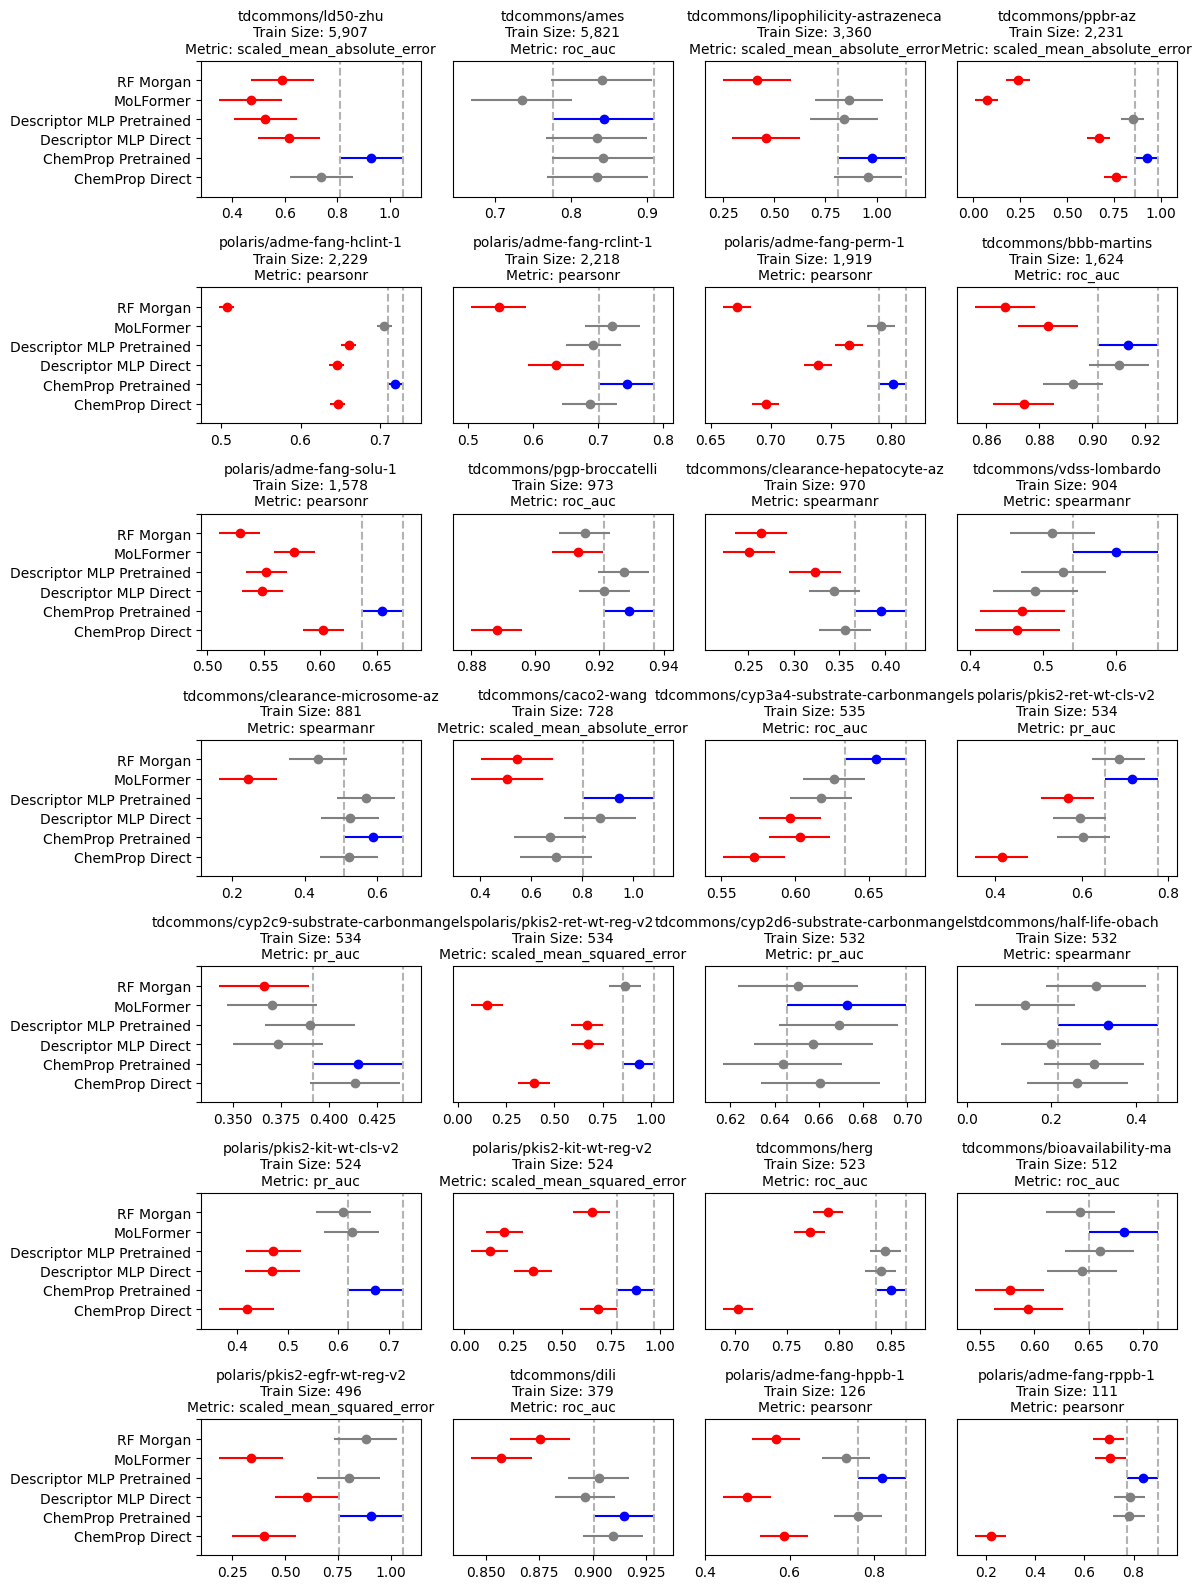

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import defaultdict
from scipy.stats import rankdata

# Prepare to collect ranks
rank_tracker = defaultdict(int)

# Step 2: Group by benchmark, perform Tukey HSD, and collect plotting info
benchmark_groups = df.groupby("benchmark", sort=False)
n_benchmarks = len(benchmark_groups)

ncols = 4
nrows = int(np.ceil(n_benchmarks / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
axes = axes.flatten()

for i, (benchmark, bench_df) in enumerate(benchmark_groups):
    ax = axes[i]
    metric_name = metrics[benchmark].label
    if metric_name in {'mean_squared_error', 'mean_absolute_error'}:
        bench_df["score"] = (bench_df["score"].max() - bench_df["score"]) / (bench_df["score"].max() - bench_df["score"].min())
        metric_name = 'scaled_' + metric_name
    
    # Run Tukey HSD
    tukey = pairwise_tukeyhsd(bench_df["score"], bench_df["model"])
    
    # Plot Tukey HSD
    comparison_name = bench_df.groupby("model")["score"].mean().idxmax()
    tukey.plot_simultaneous(comparison_name=comparison_name, ax=ax, figsize=(12, 16))
    ax.set_title(benchmark + f"\nTrain Size: {sizes[benchmark]:,}\nMetric: {metric_name}", fontdict=dict(fontsize=10))
    
    # Y-axis label tweaks
    if i % ncols != 0:
        ax.set_yticklabels([])
        ax.set_yticks([])
    else:
        ax.set_yticklabels([name.get_text().replace("_", " ") for name in ax.get_yticklabels()])

    # increment win counter for best group of models
    rank_tracker[comparison_name] += 1
    for model_name in bench_df["model"].unique():
        if model_name == comparison_name:
            continue
        else:
            tukey_df = pd.DataFrame(tukey.summary()[1:], columns=[str(i) for i in tukey.summary()[0]])
            tukey_df["group1"] = tukey_df["group1"].map(str)
            tukey_df["group2"] = tukey_df["group2"].map(str)
            if tukey_df[
                ((tukey_df["group1"] == comparison_name) & (tukey_df["group2"] == model_name)) | 
                ((tukey_df["group1"] == model_name) & (tukey_df["group2"] == comparison_name))
            ]["reject"].values[0].data == False:
                rank_tracker[model_name] += 1
                continue  # no need to check the rest

            

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("hsd.png", dpi=600)

results = pd.DataFrame.from_records(
    [{
        "model": model.replace("_", " "),
        "win count": win_count,
        "win rate (%)": 100 * win_count / n_benchmarks,
    } for model, win_count in rank_tracker.items()
    ]).sort_values(by="win rate (%)", axis=0, ascending=False)
results.round(1)
